<a href="https://colab.research.google.com/github/quartermaine/Google-Colabs/blob/master/tensorflow_image_intel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 In this notebook we are going to train a Neural network in order to classify the intel-image-classification dataset found in Kaggle.
 The data consist of 3 files (train,test,pred) with images of 6 classes.

In [2]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

#1) Donwloading and extracting data

First,  we are going to download the data using the Kaggle API and extract them to diffrent direcotries

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [4]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Jul 16 09:59 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [6]:
import os
print(os.listdir())

['.config', 'kaggle.json', 'sample_data']


In [0]:
# make kaggle directory
!mkdir -p ~/.kaggle

In [8]:
# move kaggle.json to .kaggle directory
!mv /content/kaggle.json ~/.kaggle

!chmod 600 ~/.kaggle/kaggle.json
# set the path to /content
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [9]:
# make data directory 
!mkdir -p data
# Download dataset
!kaggle datasets download -d puneet6060/intel-image-classification -p data

 93% 320M/344M [00:03<00:00, 83.1MB/s]
100% 344M/344M [00:03<00:00, 112MB/s] 


In [0]:
import os
import zipfile
# extract the files
local_zip = '/content/data/intel-image-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/intel-image-classification')
zip_ref.close()

In [11]:
def extract_files(source_dir,dest_dir):
  '''This function takes as inputs a source directory 
      and extracts any files with '.zip' extension to 
      the destination directory'''
  for file in os.listdir(source_dir):
    if file.endswith('.zip'):
      local_zip = source_dir + "/" + str(file)
      zip_ref = zipfile.ZipFile(local_zip, 'r')
      zip_ref.extractall(dest_dir)
      zip_ref.close()
  
  return print('Extraction completed')


input_dir = '/content/intel-image-classification'
out_dir = '/content/intel-image-classification'

extract_files(input_dir, out_dir)

Extraction completed


In [12]:
import tensorflow as tf
print(tf.__version__)


1.14.0


#2) Define model and Data augmentation

Next we need to define the model and we are going to use data augmentation

In [17]:
#-------------
# Define model
#-------------

weight_decay = 1e-4
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
                           input_shape=(150, 150, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.01),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay) ),
    tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.01),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay) ),
    tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.01),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay) ),
    tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.01),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay) ),
    tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.01),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dropout(0.3),
    # softmax for 6 
    tf.keras.layers.Dense(6, activation='softmax')
])

# see summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization_5 (Batch (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_6 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 64)       

In [0]:
#--------------
# Compile model
#--------------

learning_rate = 0.0005
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['acc'])


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/intel-image-classification/seg_train'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='training',
    shuffle = True) # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    shuffle = True) # set as validation data

#validation_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1./255)

# # Flow training images in batches of 128 using train_datagen generator
# train_generator = train_datagen.flow_from_directory(
#         '/content/intel-image-classification/seg_train',  # This is the source directory for training images
#         target_size=(150, 150),  # All images will be resized to 150x150
#         batch_size=128,
#         # Since we use binary_crossentropy loss, we need binary labels
#         class_mode='categorical')

# Flow training images in batches of 32 using validation_datagen generator
# validation_generator = validation_datagen.flow_from_directory(
#         '/content/intel-image-classification/seg_test',  # This is the source directory for training images
#         target_size=(150, 150),  # All images will be resized to 150x150
#         batch_size=32,
#         # Since we use binary_crossentropy loss, we need binary labels
#         class_mode='categorical')



test_generator = test_datagen.flow_from_directory('/content/intel-image-classification/seg_test',
            target_size=(150, 150), class_mode='categorical')

print('\nClasses dictionary:')

print(train_generator.class_indices)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

Classes dictionary:
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


#3) Train the model

Next, we train the model.

In [20]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15,
    verbose=1,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 50,
    validation_data = validation_generator, 
    validation_steps = 30,
    epochs = 100,
    verbose = 1,
    callbacks = [earlystop])


Epoch 1/100
50/50 [==============================] - 55s 1s/step - loss: 1.5388 - acc: 0.4892 - val_loss: 2.2753 - val_acc: 0.2111
Epoch 2/100
50/50 [==============================] - 49s 974ms/step - loss: 1.1220 - acc: 0.6003 - val_loss: 2.8846 - val_acc: 0.2025
Epoch 3/100
50/50 [==============================] - 49s 977ms/step - loss: 1.0548 - acc: 0.6118 - val_loss: 4.2234 - val_acc: 0.2213
Epoch 4/100
50/50 [==============================] - 48s 956ms/step - loss: 0.9736 - acc: 0.6480 - val_loss: 3.5349 - val_acc: 0.2654
Epoch 5/100
50/50 [==============================] - 48s 951ms/step - loss: 0.9530 - acc: 0.6601 - val_loss: 2.0988 - val_acc: 0.3636
Epoch 6/100
50/50 [==============================] - 47s 939ms/step - loss: 0.9138 - acc: 0.6739 - val_loss: 2.5188 - val_acc: 0.3446
Epoch 7/100
50/50 [==============================] - 44s 874ms/step - loss: 0.8815 - acc: 0.6889 - val_loss: 2.0660 - val_acc: 0.4023
Epoch 8/100
50/50 [==============================] - 52s 1s/step 

#4) Plots and Model Evaluation

We are going to evaluate the model using the test data and make plots for train and validation accuracy

In [21]:
#-----------------
# Model Evaluation
#-----------------
model.evaluate_generator(test_generator)

[0.578994280004755, 0.832]

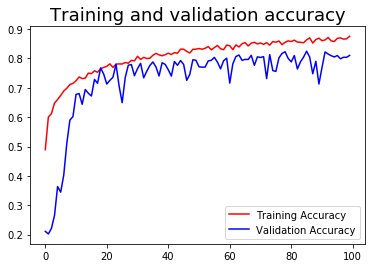

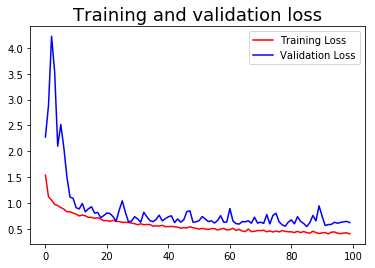

In [22]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy', color='black', size=18)
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and validation loss', color='black', size=18)
plt.legend(loc=0)


#6) Prediction

Finally, we are making predictions for using the unlabeled data

In [0]:
import numpy as np
import matplotlib.image as mpimg


labels= ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] #list to map the predictive probabilities
img_dir = "/content/intel-image-classification/seg_pred"

d={}

for image in os.listdir(img_dir):
  path = os.path.join(img_dir,image)
  img = mpimg.imread(path)
  img = img / 255.
  x = np.expand_dims(img, axis=0)

  if img.shape==(150, 150, 3):
    classes = model.predict(x, batch_size=10)
    #print("class: ",classes)
    indx = np.argmax(classes, axis=None)
    d[image]= labels[indx]



In [26]:
import random

sample = random.sample(d.items(), 12) # take random sample from predictive dataset
sample

[('2009.jpg', 'sea'),
 ('24303.jpg', 'street'),
 ('19528.jpg', 'buildings'),
 ('7435.jpg', 'mountain'),
 ('7432.jpg', 'buildings'),
 ('23751.jpg', 'forest'),
 ('6546.jpg', 'glacier'),
 ('13398.jpg', 'sea'),
 ('20340.jpg', 'forest'),
 ('4585.jpg', 'forest'),
 ('19099.jpg', 'glacier'),
 ('19135.jpg', 'forest')]

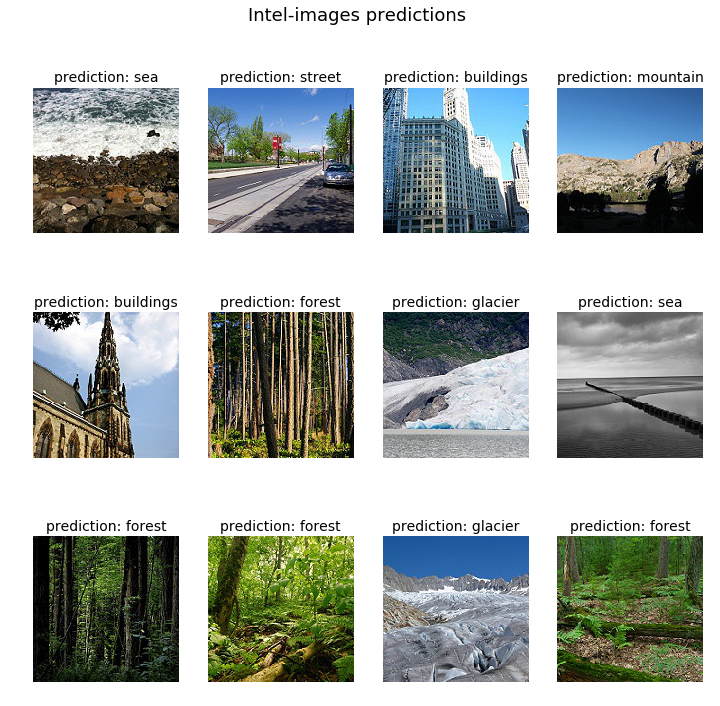

In [28]:
plt.figure(figsize=(12,11))
plt.subplots_adjust(hspace=0.5)
for i,n in enumerate(sample):
  plt.subplot(3,4,i+1)
  read_img = mpimg.imread('/content/intel-image-classification/seg_pred/'+n[0])
  plt.title("prediction: "+n[1],color = 'black', size=14)
  plt.imshow(read_img)
  plt.axis('off')
  
_ = plt.suptitle("Intel-images predictions", color='black', size=18)
